**Download Dataset**

In [26]:
!wget -nv "https://www.dropbox.com/s/elovlw3g8ylv85m/train.csv"

2021-10-02 07:41:44 URL:https://ucc8d377f06e91c2ca27000753f7.dl.dropboxusercontent.com/cd/0/inline/BXRYNWF7WGRq1rzANNQ0-67n85NU8dmLVDdWMaiIbVJhMSedg8NcJFGifBJp6E37xcETtQH3_-fKm1k-9byRu6WjK6ZiWMvFhZ4XoJeke6NqNxlJx2KLlQ_XuvRTC1Ko4_d-dLRxvACEfFgARsPERc80/file [240699943/240699943] -> "train.csv.1" [1]


**Import Libraries**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D ,BatchNormalization
from tensorflow.keras.optimizers import Adam

**Make Dataframe**

In [28]:
df=pd.read_csv('train.csv')

Emotions and Corresponding Labels

In [29]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

**Exploratory Data Analysis**

In [30]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


([<matplotlib.axis.XTick at 0x7f005aa7a150>,
 [Text(0, 0, 'Angry'),
  Text(1, 0, 'Disgust'),
  Text(2, 0, 'Fear'),
  Text(3, 0, 'Happy'),
  Text(4, 0, 'Sad'),
  Text(5, 0, 'Surprise'),
  Text(6, 0, 'Neutral')])

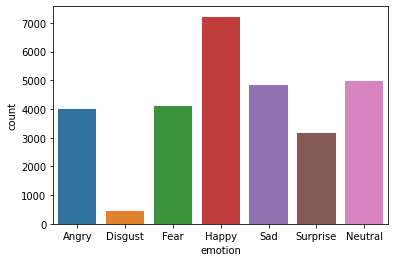

In [32]:
sns.countplot(data = df, x='emotion')
plt.xticks([0,1,2,3,4,5,6],emotions.values())

**Data Preprocessing**

We need class_weights to manage the class imbalances in the dataset.

In [33]:
class_weight = dict(zip(range(0, 7), (((df['emotion'].value_counts()).sort_index())/len(df['emotion'])).tolist()))

In [34]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

We need to Prepare the pixels that are currently in a 1D String format into 2D images and make a aray of these images.

In [35]:
def make_images_array(data):    
    images_array = np.zeros(shape=(len(data), 48, 48))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        images_array[i] = image
        
    return images_array

In [36]:
x = make_images_array(df)

In [37]:
y = df.emotion.to_numpy()

Displaying the first few images of the dataset.

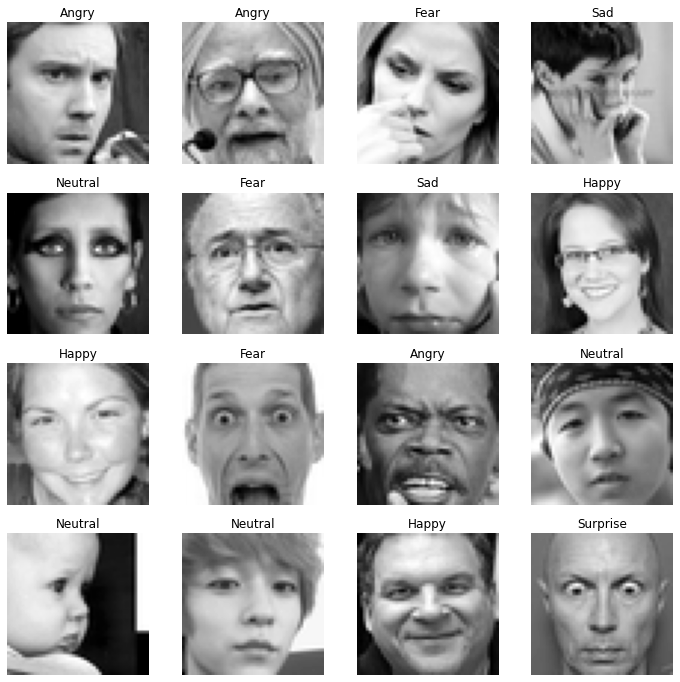

In [38]:
x_display = x[0:17,:,:]
y_display = y[0:17]
plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_display[i,:,:], cmap='binary_r')
    plt.title(emotions[y_display[i]])
    plt.axis('off')
plt.show()

Spliting data to train and test data.

In [39]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,shuffle = True)

Genrate Binary Matrix for classes.

In [40]:
y_train=to_categorical(y_train, num_classes=len(df.emotion.unique()))  
y_test=to_categorical(y_test, num_classes=len(df.emotion.unique())) 

Reshape the input Data to 4D as Convolution Layer needs a 4D input (Number of Images, width, height and depth of output)

In [41]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1) 

In [42]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [43]:
x_train.shape

(25838, 48, 48, 1)

**Model Building**

In [44]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(256,(3,3), activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(256,(3,3), activation='relu',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512,(3,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten()) 
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test),class_weight = class_weight, epochs=100, batch_size=64)

Epoch 1/100
404/404 [==============================] - 9s 20ms/step - loss: 0.4753 - accuracy: 0.1994 - val_loss: 1.8943 - val_accuracy: 0.2626
Epoch 2/100
404/404 [==============================] - 7s 19ms/step - loss: 0.3456 - accuracy: 0.2227 - val_loss: 1.8315 - val_accuracy: 0.2626
Epoch 3/100
404/404 [==============================] - 8s 19ms/step - loss: 0.3172 - accuracy: 0.2333 - val_loss: 1.8139 - val_accuracy: 0.2626
Epoch 4/100
404/404 [==============================] - 8s 19ms/step - loss: 0.3023 - accuracy: 0.2451 - val_loss: 1.8275 - val_accuracy: 0.2626
Epoch 5/100
404/404 [==============================] - 7s 19ms/step - loss: 0.2962 - accuracy: 0.2500 - val_loss: 1.8477 - val_accuracy: 0.2626
Epoch 6/100
404/404 [==============================] - 7s 19ms/step - loss: 0.2914 - accuracy: 0.2476 - val_loss: 1.8710 - val_accuracy: 0.2626
Epoch 7/100
404/404 [==============================] - 7s 18ms/step - loss: 0.2888 - accuracy: 0.2529 - val_loss: 1.8721 - val_accuracy:

**Check Accuracy**

<AxesSubplot:>

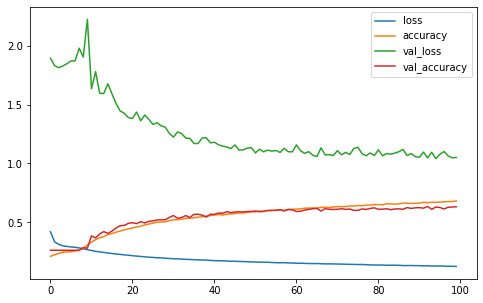

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [48]:
train_loss, train_acc = model.evaluate(x_train, y_train)
print('accuracy:', train_acc)

808/808 [==============================] - 4s 4ms/step - loss: 0.6810 - accuracy: 0.7480
accuracy: 0.7480455040931702


In [49]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('accuracy:', test_acc)

90/90 [==============================] - 0s 5ms/step - loss: 1.0515 - accuracy: 0.6325
accuracy: 0.6325322389602661


**Save Model and Weights**

In [50]:
model_json = model.to_json()
model.save_weights('fer_model_weights.h5')
with open("fer_model.json", "w") as json_file:
  json_file.write(model_json)